## Chapter 3

### MNIST 데이터셋

In [50]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)    # MNIST set을 dictionary형태로 불러옴

In [51]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [72]:
X, y = mnist["data"], mnist["target"]

In [73]:
# 70000개의 이미지와 각 이미지별 784개의 특성(28*28 픽셀). 각 특성은 0~255(흰색~검은색)값을 가짐.
print(X.shape, y.shape)

(70000, 784) (70000,)


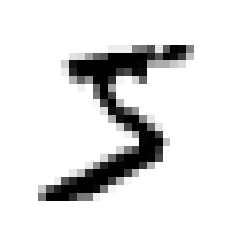

5


In [74]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print(y[0])


In [75]:
# 문자열 레이블을 정수로 변환
import numpy as np

print(type(y[0]))

y=y.astype(np.uint8)

<class 'str'>


In [76]:
# train/test set 분리.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 이진 분류기

* 5를 감지하는 분류기 만들기

In [77]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [78]:
# SGDClassifier(확률적 경사 하강법) 사용
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [79]:
# some_digit은 5가 그려진 이미지
sgd_clf.predict([some_digit])

array([ True])

* 성능 측정

In [61]:
# k-fold cross validation 사용
# 성능 측정 지표는 정확도.(95%이상이 나옴)
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [64]:
# 모든 이미지를 '5가 아님'으로 분류하는 분류기를 만들어 성능 측정
# 그냥 모든 이미지를 5가 아님으로 분류했음에도 정확도가 90%가 넘음. 즉, 정확도는 분류기의 성능 측정 지표로 적절하지 않고, 데이터셋이 불균형하다면 더욱 적절하지 않다.
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self;
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [80]:
# 오차 행렬(confusion matrix)로 분류기의 성능 평가
# 클래스 A의 샘플이 클래스 B로 분류된 횟수를 셈(ex. 분류기가 이미지 5를 숫자 3으로 분류한 횟수를 볼려면 오차 행렬의 5행 3열 확인).
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # k-fold cross validation을 수행하면서 평가 점수를 반환하지 않고 각 fold에서 얻은 예측을 반환.

In [81]:
# 오차 행렬 만들기
# 오차 행렬의 행은 실제 클래스, 열은 예측한 클래스를 나타냄.
# 첫 번째 행은 '5가 아님'(negative class, 음성 클래스)을 나타내고 53892개를 5가 아님으로 분류했고(true negative, 진짜 음성) 687개를 5라고 잘못 분류함(false positive, 거짓 양성).
# 두 번째 행은 '5'(positive class, 양성 클래스)를 나타내고 1891개를 5가 아님으로 잘못 분류했고(false negative, 거짓 음성) 3530개를 5라고 분류함(true positive, 진짜 양성).

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [82]:
# 분류가 완벽했다면 왼쪽 아래에서 시작하는 대각선 방향의 값은 0이 되어야 한다.
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

> 양성 예측의 정확도를 정밀도(precision)라고 함. 정밀도는 보통 분류기가 정확하게 감지한 양성 샘플의 비율인 재현율(recall, 민감도 또는 진짜 양성 비율)이라는 지표와 같이 사용.    
> 
> <div align="center"><img src="https://latex.codecogs.com/svg.image?precision=\frac{TP}{TP&plus;FP}&space;recall=\frac{TP}{TP&plus;FN}" title="precision=\frac{TP}{TP+FP} recall=\frac{TP}{TP+FN}" /></div>    
> 
> * TP : 진짜 양성의 수    
> * FP : 거짓 양성의 수    
> * FN : 거짓 음성의 수    

In [83]:
# sklearn으로 정밀도와 재현율 계산
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


> 정밀도와 재현율을 하나로 표현한 것을 F1점수라고 함(정밀도와 재현율의 조화 평균).    
> <div align="center"><img src="https://latex.codecogs.com/svg.image?F_{1}&space;=&space;\frac{2}{\frac{1}{precision}&space;&plus;&space;\frac{1}{recall}}&space;=&space;\frac{TP}{TP&space;&plus;&space;\frac{FN&space;&plus;&space;FP}{2}}" title="F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}" /></div>

In [84]:
# f1 score 계산. 상황에 따라 정밀도, 재현율, f1 score중 알맞은 것을 선택하여 평가해야함.
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846